# Import

In [2]:
# import libraries
import os
import csv
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pickle as pk
import mdptoolbox as mt
import mdptoolbox.example
import itertools
import collections
import time
import multiprocessing

# Network

In [3]:
# set network parameters
nodeList = [1, 2]

# original external arrivals
arrPara = {}
arrPara[1] = 0.2
arrPara[2] = 0.1

# neighborhood connectivities
neiPara = {}
neiPara[1] = [-1]
neiPara[2] = [-1]

# success rate
successPara = {}
successPara[1] = 0.3
successPara[2] = 0.95

# buffer size
buffer_size = 10000

In [4]:
class Network:

    # initialization
    def __init__(self):
        self.Q = collections.defaultdict(int)

    # external arrivals
    def Arrive(self, arrival):
        for i in nodeList:
            self.Q[i] = min(buffer_size, self.Q[i]+arrival[i])

    # service
    def Serve(self, action):
        # service
        ser = {}
        for i in nodeList:
            for j in neiPara[i]:
                ser[(i, j)] = min(action[(i, j)], self.Q[i])
                self.Q[i] -= ser[(i, j)]
        # receive internal arrivals
        for i in nodeList:
            for j in neiPara[i]:
                if j != -1:
                    self.Q[j] += ser[(i, j)]

# Simulation

In [5]:
class Simulation:
    
    # initialization
    def __init__(self, sim_para):
        self.method = sim_para['method']
        self.sample_num = sim_para['sample_num']
        self.time_horizon = sim_para['time_horizon']
        self.is_display_progress = sim_para['is_display_progress']
        self.qLog = collections.defaultdict(list)
        self.tLog = collections.defaultdict(list)
        self.arr_count = {node: [0, 0] for node in nodeList}
        self.success_count = {node: [0, 0] for node in nodeList}

    def Simulate(self):
        for n in range(self.sample_num): 
            self.net = Network()
            self.solver = self.Solver()
            start_time = time.time()
            for t in range(self.time_horizon):
                # arrivals
                self.net.Arrive(self.Arrival())
                # service
                self.net.Serve(self.Service(t))
                # record data
                self.qLog[n].append(dict(self.net.Q))
                self.tLog[n].append(time.time() - start_time)
                # display process
                self.DisplayProcess(n, start_time, t)
            self.solver = None
            self.net = None
        return
        
    def Solver(self):
        if self.method == 'LQ':
            return LQ(self.method)
        elif self.method[:4] == 'NOpt':
            return NOpt(self.method)
        elif self.method[:4] == 'RLQN':
            return RLQN(self.method)
        
    def Arrival(self):
        arrival = {}
        for node in arrPara:
            arrival[node] = np.random.choice([0, 1], 1,  p = [1 - arrPara[node], arrPara[node]])[0]
            self.arr_count[node][0] += 1
            self.arr_count[node][1] += arrival[node]
        return arrival
    
    def Service(self, t):
        served_node = self.solver.Action(self.net.Q, t, self.arr_count, self.success_count)
        service = collections.defaultdict(int)
        service[(served_node, -1)] = np.random.choice([0, 1], 1,  p = [1 - successPara[served_node], successPara[served_node]])[0]
        self.success_count[served_node][0] += 1
        self.success_count[served_node][1] += service[(served_node, -1)]
        return service
        
    def DisplayProcess(self, n, start_time, t):
        if t % 20 == 0:
            print('\r' + self.method + ', n = ' + str(n) + ', t = ' + str(t) + ', ' + str(time.time()-start_time), end='')
        elif t == self.time_horizon - 1:
            print('\r' + self.method + ', n = ' + str(n) + ', t = ' + str(t) + ', ' + str(time.time()-start_time), end='\n')
        return

# Algorithms

## LQ

In [6]:
class LQ:
    
    # initialization
    def __init__(self, method):
        return
    
    # compute the action
    def Action(self, Q, t, arr_count, success_count):
        served_node, max_q = nodeList[0], Q[nodeList[0]]
        for node in nodeList:
            if Q[node] > max_q:
                served_node, max_q = node, Q[node]
        return served_node 

## Near Optimal

In [7]:
class NOpt:
    
    # initialization
    def __init__(self, method):
        self.U = float('inf') if method == 'NOpt' else int(method[4:])
        self.LQ = LQ(method)
    
    # compute the action
    def Action(self, Q, t, arr_count, success_count):
        # if outside the boundary, apply LQ
        if max(Q.values()) > self.U:
            return self.LQ.Action(Q, t)
        # otherwise, serve the non-empty queue with the largest success rate
        served_node, max_p = nodeList[0], successPara[nodeList[0]]
        for idx in range(1, len(nodeList)):
            node = nodeList[idx]
            if Q[node] and successPara[node] > max_p:
                served_node, max_p = node, successPara[node]
        return served_node 

## RL-QN

In [8]:
class RLQN:

    # initialization
    def __init__(self, method):
        para = method.split('_')
        self.U = int(para[1])
        self.l = float(para[2]) 
        self.L = int(para[3])
        self.MDP_solver_type = para[4]
        self.MDP_solver = None
        self.is_rand = False
        self.episode = 1
        self.coin_toss_time = 0
        self.visit = collections.defaultdict(int)
        self.success = collections.defaultdict(int)
        self.est_successPara = collections.defaultdict(lambda:0.5)
        self.LQ = LQ(method)
            
    # compute the action
    def Action(self, Q, t, arr_count, success_count):
        if t == self.coin_toss_time:
            # decide whether to start a new episode
            prob_rand = self.l/math.sqrt(self.episode)
            self.is_rand = np.random.choice([True, False], 1,  p = [prob_rand, 1-prob_rand])[0]
            self.coin_toss_time += int(self.L*math.sqrt(self.episode))
            self.episode += 1
            # estimate arrival rate and success rate
            est_arrPara = {}
            est_successPara = {}
            for node in nodeList:
                est_arrPara[node] = 0.5 if arr_count[node][0] == 0 else arr_count[node][1]/arr_count[node][0]
                est_successPara[node] = 0.5 if success_count[node][0] == 0 else success_count[node][1]/success_count[node][0]
            # if exploitation, compute the approxiamted optimal policy
            if not self.is_rand:
                P_sas = self.CompP_sas(est_arrPara, est_successPara)
                R = self.CompReward()
                # value iteration
                if self.MDP_solver_type == 'VI':
                    self.MDP_solver = mt.mdp.ValueIteration(P_sas, R, 0.99, epsilon=0.05)
                # relative value iteration
                elif self.MDP_solver_type == 'RVI':
                    self.MDP_solver = mt.mdp.RelativeValueIteration(P_sas, R, epsilon=0.05)
                # policy iteration
                elif self.MDP_solver_type == 'PI':
                    self.MDP_solver = mt.mdp.PolicyIteration(P_sas, R, 0.99)
                # solve the MDP
                self.MDP_solver.run()  
        # if outside the boundary, apply LQ
        if max(Q.values()) > self.U:
            return self.LQ.Action(Q, t, None, None)
        # if apply random policy during this episode
        if self.is_rand:
            return random.choice(nodeList)
        # if apply RL during this episode
        return nodeList[self.MDP_solver.policy[self.QtoIdx(Q)]]

    # compute the index of a given state
    def QtoIdx(self, Q):
        N = len(nodeList)
        return sum(Q[node]*(self.U+1)**(N-1-i) for i, node in enumerate(nodeList))
    
    # compute state transition metrix based on the given probabilities
    def CompP_sas(self, arr_rate, ser_rate):
        N = len(nodeList)
        P_sas = []
        for node in nodeList:
            # the state transition matrix when the node is selected
            P_ss = [[0] * (self.U+1)**N for _ in range((self.U+1)**N)]
            # for all Q
            for start_Q in itertools.product(range(self.U+1), repeat = N):
                start_Q = {q:start_Q[i] for i, q in enumerate(nodeList)}
                # for all possible dQ:
                for d_Q in itertools.product([-1, 0, 1], repeat = N):
                    p = 1
                    d_Q = {q:d_Q[i] for i, q in enumerate(nodeList)}
                    end_Q = {}
                    # for each node
                    for cur_node in nodeList:
                        # probability for d_q[i]
                        if cur_node == node:
                            if d_Q[cur_node] == -1:
                                p *= (1 - arr_rate[cur_node])*ser_rate[cur_node]
                            elif d_Q[cur_node]  == 1:
                                p *= arr_rate[cur_node]*(1 - ser_rate[cur_node])
                            else:
                                p *= arr_rate[cur_node]*ser_rate[cur_node] + (1 - arr_rate[cur_node])*(1 - ser_rate[cur_node])
                        else:
                            if d_Q[cur_node] == -1:
                                p = 0
                            elif d_Q[cur_node] == 1:
                                p *= arr_rate[cur_node]
                            else:
                                p *= (1 - arr_rate[cur_node])
                        # the end Q
                        end_q = max(min(start_Q[cur_node]+d_Q[cur_node], self.U), 0)
                        end_Q[cur_node] = end_q
                    # update P_ss
                    P_ss[self.QtoIdx(start_Q)][self.QtoIdx(end_Q)] += p
            # update P_sas
            P_sas.append(P_ss)
        return np.array(P_sas)
    
    # compute the reward matrix
    def CompReward(self):
        N = len(nodeList)
        R = [[0] * N for _ in range((self.U+1)**N)]
        for Q in itertools.product(range(self.U+1), repeat = N):
            total_q = sum(Q)
            Q = {q:Q[i] for i, q in enumerate(nodeList)}
            R[self.QtoIdx(Q)] = [-total_q] * N
        return np.array(R)

# Convergence

In [9]:
sim_para = {}
sim_para['time_horizon'] = 200000
sim_para['sample_num'] = 5
sim_para['is_display_progress'] = True

sim_para['path'] = ('SA_' + str(len(nodeList)) +
                    "/Conv_T" + str(sim_para['time_horizon']) + 
                    "_SN" + str(sim_para['sample_num']) + '/')
os.makedirs(sim_para['path'], exist_ok=True)

method_list = ['LQ', 'RLQN_5_0.05_100_VI', 'RLQN_10_0.05_100_VI', 'RLQN_20_0.05_100_VI', 'NOpt']

In [ ]:
# compute the total queue
def ComputeTotalQ(qLog):
    total_q = [0] * sim_para['time_horizon']
    for sample in range(sim_para['sample_num']):
        sampled_Q = qLog[sample]
        for t in range(sim_para['time_horizon']):
            Q = sampled_Q[t]
            total_q[t] += sum(Q[node] for node in nodeList)/sim_para['sample_num']
    return total_q

# compute the average queue
def ComputeAveQ(qLog):
    total_q = ComputeTotalQ(qLog)
    ave_q = [0] * sim_para['time_horizon']
    ave_q[0] = total_q[0]
    for t in range(1, sim_para['time_horizon']):
        ave_q[t] = ave_q[t-1]*t/(t+1) + total_q[t]/(t+1)
    return ave_q

# simulate
for method in method_list:
    sim_para['method'] = method
    sim = Simulation(sim_para)
    sim.Simulate()
    pk.dump(ComputeAveQ(sim.qLog), open(sim_para['path'] + method, "wb"))

In [10]:
# read data
Q_plot = {}
for method in method_list:
    Q_plot[method] = pk.load(open(sim_para['path'] + method, "rb"))
    print(method, Q_plot[method][-1])

LQ 2.9532580000000075
RLQN_5_0.05_100_VI 2.3793180000000427
RLQN_10_0.05_100_VI 2.236449000000001
RLQN_20_0.05_100_VI 2.2415619999999308
NOpt 2.1764740000001153


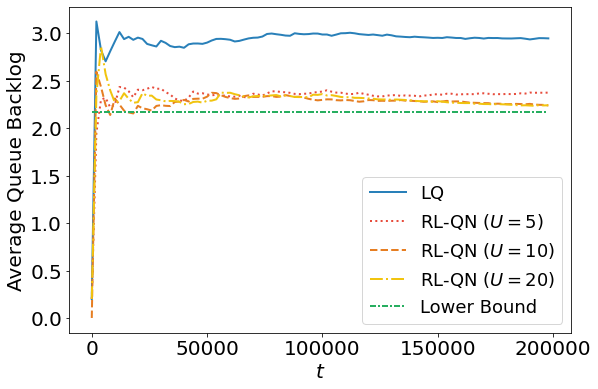

In [12]:
# drawing
labelSize = 20
legendSize = 18
figSize = (9, 6)
lineWidth = 2
subSample = sim_para['time_horizon']//100
t_plot = np.arange(0.0, sim_para['time_horizon'], subSample)

# plotting
fig = plt.figure(figsize=figSize)
ax = fig.gca()
color_set = ['#2980B9', '#E74C3C', '#E67E22', '#F1C40F', '#27AE60']
linestyle_set = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
legend_set = []
idx = 0
for method in method_list:
    legend = ''
    if method == 'LQ':
        legend = 'LQ'
    elif method[:4] == 'RLQN':
        para = method.split('_')
        legend = 'RL-QN ($U=' + para[1] + '$)'
    elif method == 'NOpt':
        legend = 'Lower Bound'
        Q_plot['NOpt'] = [2.17648]*sim_para['time_horizon']
    ax.plot(t_plot, Q_plot[method][::subSample], color_set[idx], 
            linewidth=lineWidth, linestyle=linestyle_set[idx], label=legend)
    idx += 1

# labels
ax.tick_params(labelsize=labelSize)
ax.legend(prop={"size":legendSize})
plt.xlabel('$t$', fontsize=labelSize)
plt.ylabel('Average Queue Backlog', fontsize=labelSize)
plt.show()

# Time Complexity

In [13]:
# tune MDP solver parameters
rep = 20
solver = RLQN("RLQN_20_0.2_100_VI")
P_sas = solver.CompP_sas(arrPara, successPara)
R = solver.CompReward()
ave_comp_time = collections.defaultdict(list)

MDP_solver = None
for _ in range(rep):
    for MDP_solver_type in ['VI', 'RVI', 'PI']:
        start_time = time.time()
        # value iteration
        if MDP_solver_type == 'VI':
            MDP_solver = mt.mdp.ValueIteration(P_sas, R, 0.99, epsilon=0.05)
        # relative value iteration
        elif MDP_solver_type == 'RVI':
            MDP_solver = mt.mdp.RelativeValueIteration(P_sas, R, epsilon=0.05)
        # policy iteration
        elif MDP_solver_type == 'PI':
            MDP_solver = mt.mdp.PolicyIteration(P_sas, R, 0.99)
        # solve the MDP
        MDP_solver.run()
        ave_comp_time[MDP_solver_type].append(time.time() - start_time)
        
print([(MDP_solver_type, 100*np.mean(ave_comp_time[MDP_solver_type])) for MDP_solver_type in ['VI', 'RVI', 'PI']])

[('VI', 3.4532928466796875), ('RVI', 3.7494194507598873), ('PI', 1.1626160144805908)]


In [14]:
sim_para = {}
sim_para['time_horizon'] = 1000000
sim_para['sample_num'] = 10
sim_para['is_display_progress'] = True

sim_para['U_list'] = [U for U in range(1, 21)]
sim_para['l'] = 0.1
sim_para['L'] = 50
sim_para['MDP_solver_type'] = ['VI', 'RVI', 'PI']

sim_para['path'] = ('SA_' + str(len(nodeList)) +
                    "/QT_T" + str(sim_para['time_horizon']) + 
                    "_SN" + str(sim_para['sample_num']) + 
                    '_l' + str(sim_para['l']) + 
                    '_L' + str(sim_para['L']) + '/')
os.makedirs(sim_para['path'], exist_ok=True)

method_list = ['LQ']
for U in sim_para['U_list']:
    for MDP_solver_type in sim_para['MDP_solver_type']:
        method_list.append('RLQN_' + str(U) + '_' + str(sim_para['l']) + '_' + 
                           str(sim_para['L']) + '_' + MDP_solver_type)

In [ ]:
# compute the average computation time
def GetT(tLog):
    return [T[-1] for T in tLog.values()]

# compute the minimum average queue among samples
def GetAveQ(qLog):
    q_list = []
    for sample_Q in qLog.values():
        ave_q = 0
        for t in range(sim_para['time_horizon']):
            ave_q += sum(sample_Q[t][node] for node in nodeList)
        ave_q /= sim_para['time_horizon']
        q_list.append(ave_q)
    return q_list

# simulate
for method in method_list:
    sim_para['method'] = method
    sim = Simulation(sim_para)
    sim.Simulate()
    pk.dump([GetT(sim.tLog), GetAveQ(sim.qLog)], open(sim_para['path'] + method, "wb"))

In [15]:
# read data
QT_data = collections.defaultdict(list)

# read LQ data
QT_data['LQ'] = pk.load(open(sim_para['path'] + 'LQ', "rb"))

# read RL-QN data
method_list = []
for U in sim_para['U_list']:
    for MDP_solver_type in sim_para['MDP_solver_type']:
        method = 'RLQN_' + str(U) + '_' + str(sim_para['l']) + '_' + str(sim_para['L']) + '_' + MDP_solver_type
        QT = pk.load(open(sim_para['path'] + method, "rb"))
        QT_data[MDP_solver_type].append(QT)

In [16]:
# process data
T_plot = collections.defaultdict(list)
Q_plot = collections.defaultdict(list)

# process LQ data
T_plot['LQ'] = np.mean(QT_data['LQ'][0])
Q_plot['LQ'] = np.mean(QT_data['LQ'][1])

# process RL-QN data
for MDP_solver_type in sim_para['MDP_solver_type']:
    for T, Q in QT_data[MDP_solver_type]:
        T_plot[MDP_solver_type].append(np.mean(T)/T_plot['LQ'])
#         Q.sort()
#         Q_plot[MDP_solver_type].append(np.mean(Q[3:7]))
        Q.sort(reverse=True)
        if not Q_plot[MDP_solver_type]:
            Q_plot[MDP_solver_type].append(Q[2])
        else:
            last_q = Q_plot[MDP_solver_type][-1]
            for idx, q in enumerate(Q):
                if q < last_q or idx == len(Q)-1:
                    Q_plot[MDP_solver_type].append(q)
                    break

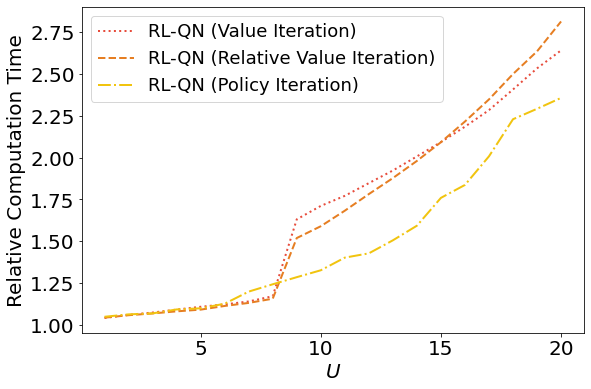

In [17]:
# parameters for drawing
labelSize = 20
legendSize = 18
figureSize = (9, 6)
scatterSize = 100
lineWidth = 2
    
# plotting
fig = plt.figure(figsize=figureSize)
ax = fig.gca()

# plot RL-QN results
color_list = ['#E74C3C', '#E67E22', '#F1C40F']
linestyle_list = ['dotted', 'dashed', 'dashdot']
idx = 0
for MDP_solver_type in sim_para['MDP_solver_type']:
    legend = ''
    if MDP_solver_type == 'VI':
        legend = 'RL-QN (Value Iteration)'
    elif MDP_solver_type == 'RVI':
        legend = 'RL-QN (Relative Value Iteration)'
    elif MDP_solver_type == 'PI':
        legend = 'RL-QN (Policy Iteration)'
    ax.plot([x for x in range(1, 21)], T_plot[MDP_solver_type], 
            color_list[idx], linewidth=lineWidth, linestyle=linestyle_list[idx], label=legend)
    idx += 1

# labels
ax.tick_params(labelsize=labelSize)
ax.legend(prop={"size":legendSize})
plt.xlabel('$U$', fontsize=labelSize)
plt.ylabel('Relative Computation Time', fontsize=labelSize)
plt.show()

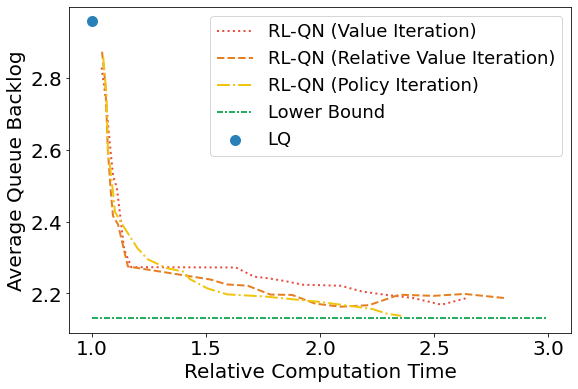

In [19]:
# parameters for drawing
labelSize = 20
legendSize = 18
figureSize = (9, 6)
scatterSize = 100
lineWidth = 2
    
# plotting
fig = plt.figure(figsize=figureSize)
ax = fig.gca()

# plot RL-QN results
color_list = ['#E74C3C', '#E67E22', '#F1C40F']
linestyle_list = ['dotted', 'dashed', 'dashdot']
idx = 0
for MDP_solver_type in sim_para['MDP_solver_type']:
    legend = ''
    if MDP_solver_type == 'VI':
        legend = 'RL-QN (Value Iteration)'
    elif MDP_solver_type == 'RVI':
        legend = 'RL-QN (Relative Value Iteration)'
    elif MDP_solver_type == 'PI':
        legend = 'RL-QN (Policy Iteration)'
    ax.plot(T_plot[MDP_solver_type], Q_plot[MDP_solver_type], 
            color_list[idx], linewidth=lineWidth, linestyle=linestyle_list[idx], label=legend)
    idx += 1

# plot lower bound
ax.plot([x for x in range(1, 4)], [2.1317]*3, '#27AE60', linewidth=lineWidth, linestyle=(0, (3, 1, 1, 1)), label="Lower Bound")

# plot LQ
ax.scatter(1, Q_plot['LQ'], marker='o', color='#2980B9', s=scatterSize, zorder=100, label='LQ')

# labels
ax.tick_params(labelsize=labelSize)
ax.legend(prop={"size":legendSize})
plt.xlabel('Relative Computation Time', fontsize=labelSize)
plt.ylabel('Average Queue Backlog', fontsize=labelSize)
plt.show()

In [20]:
print(Q_plot['LQ'], T_plot['VI'][7], Q_plot['VI'][7])
print((2.9582196-2.273349)/2.9582196)

2.9582196 1.1728674551528784 2.273349
0.23151445551912372


# Hitting Time

In [22]:
sim_para = {}
sim_para['time_horizon'] = 1000000
sim_para['sample_num'] = 1
sim_para['is_display_progress'] = True
sim_para['method'] = 'LQ'

sim_para['path'] = ('SA_' + str(len(nodeList)) +
                    "/HT_T" + str(sim_para['time_horizon']) + '/')
os.makedirs(sim_para['path'], exist_ok=True)

buffer_size = 10

In [86]:
# simulate
sim = Simulation(sim_para)
sim.Simulate()
pk.dump(sim.qLog, open(sim_para['path'] + sim_para['method'], "wb"))

LQ, n = 0, t = 4999, 0.71861767768859863


In [26]:
# read data
qLog = pk.load(open(sim_para['path'] + sim_para['method'], "rb"))

# compute the distance between two queues
def Distance(Q_1, Q_2):
    dist = 0
    for node in nodeList:
        dist += abs(Q_1[node] - Q_2[node])
    return dist

# compute the average hitting time
start_time = time.time()
hitting_time = collections.defaultdict(list)
for start_t, start_Q in enumerate(qLog[0]):
    trace = {tuple(start_Q[node] for node in nodeList)}
    for end_t in range(start_t+1, min(start_t+100, sim_para['time_horizon'])):
        end_Q = qLog[0][end_t]
        end_Q_tuple = tuple(end_Q[node] for node in nodeList)
        if end_Q_tuple not in trace:
            hitting_time[Distance(start_Q, end_Q)].append(end_t - start_t)
            trace.add(end_Q_tuple)
    if start_t%1000 == 99:
        print('\r t =', start_t, ', time consumed:', time.time()-start_time, end='')
pk.dump(hitting_time, open(sim_para['path'] + "hitting_time", "wb"))

 t = 999099 , time consumed: 106.45960402488708

In [27]:
# process data
hitting_time = pk.load(open(sim_para['path'] + "hitting_time", "rb"))

dt_data = []
for d in hitting_time:
    dt_data.append((d, np.mean(hitting_time[d])))
dt_data.sort()

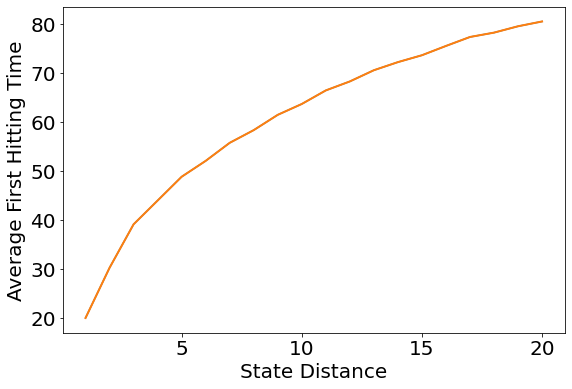

In [28]:
# parameters for drawing
labelSize = 20
legendSize = 18
figureSize = (9, 6)
scatterSize = 100
lineWidth = 2
    
# plotting
fig = plt.figure(figsize=figureSize)
ax = fig.gca()

# plot LQ
plt.plot([dt[0] for dt in dt_data], [dt[1] for dt in dt_data])
ax.plot([dt[0] for dt in dt_data], [dt[1] for dt in dt_data], linewidth=lineWidth)

# labels
ax.tick_params(labelsize=labelSize)
plt.xlabel('State Distance', fontsize=labelSize)
plt.ylabel('Average First Hitting Time', fontsize=labelSize)
plt.show()